# **Needed Libraries**

In [ ]:
! pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 9.7 MB/s eta 0:00:00


In [3]:
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import os
from PIL import Image
import cv2
import seaborn as sns
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# **Dataset Loading**

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! kaggle datasets download -d ravirajsinh45/real-life-industrial-dataset-of-casting-product

 99% 99.0M/100M [00:05<00:00, 27.8MB/s]
100% 100M/100M [00:05<00:00, 19.3MB/s] 


In [ ]:
!unzip /content/real-life-industrial-dataset-of-casting-product.zip

In [4]:
image_shape = (300,300,1) # 300 × 300、graysclaed
batch_size = 32
train_path = '/content/casting_data/casting_data/train'
test_path = '/content/casting_data/casting_data/test'
image_gen = ImageDataGenerator(rescale=1/255, 
                               zoom_range=0.1, 
                               brightness_range=[0.9,1.0])

train_set = image_gen.flow_from_directory(train_path,
                                            target_size=image_shape[:2],
                                            color_mode="grayscale",
                                            classes={'def_front': 0, 'ok_front': 1},
                                            batch_size=batch_size,
                                            class_mode='binary',
                                            shuffle=True,
                                            seed=0)

test_set = image_gen.flow_from_directory(test_path,
                                           target_size=image_shape[:2],
                                           color_mode="grayscale",
                                           classes={'def_front': 0, 'ok_front': 1},
                                           batch_size=batch_size,
                                           class_mode='binary',
                                           shuffle=False,
                                           seed=0)

Found 6633 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


# **Dataset Featuring**

In [5]:
x_train = []
y_train = []
for i in range(len(train_set)):
    batch_x, batch_y = train_set.next()
    x_train.append(batch_x)
    y_train.append(batch_y)
x_train = np.concatenate(x_train)
y_train = np.concatenate(y_train).reshape(-1, 1)

x_test = []
y_test = []
for i in range(len(test_set)):
    batch_x, batch_y = test_set.next()
    x_test.append(batch_x)
    y_test.append(batch_y)
x_test = np.concatenate(x_test, axis=0)
y_test = np.concatenate(y_test, axis=0).reshape(-1, 1)

In [6]:
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")
type(x_train)

x_train shape: (6633, 300, 300, 1) - y_train shape: (6633, 1)
x_test shape: (715, 300, 300, 1) - y_test shape: (715, 1)


numpy.ndarray

[1.]


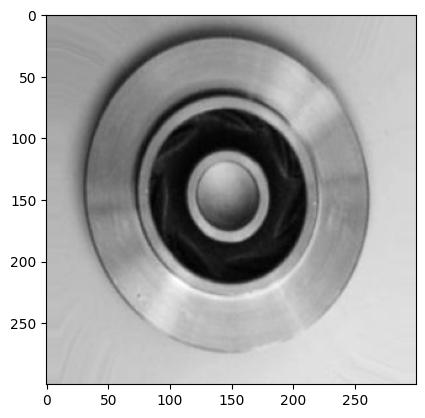

[0.]


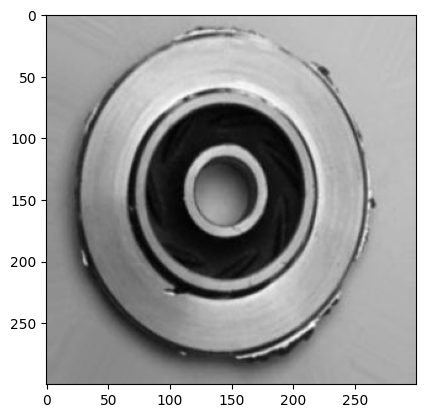

In [7]:
print(y_train[8])
plt.imshow(x_train[8],cmap='gray')
plt.show()
print(y_train[1])
plt.imshow(x_train[1],cmap='gray')
plt.show()
# 1 = ok , 0 = def

In [8]:
lb = LabelEncoder()
y_train = lb.fit_transform(y_train) 
y_test = lb.fit_transform(y_test) 

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# **Model Building**

In [9]:
num_classes = 2
input_shape = (300, 300, 1)
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 10
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [10]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [11]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [12]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 36


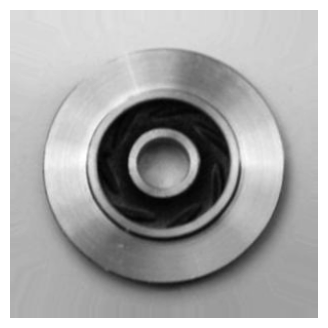

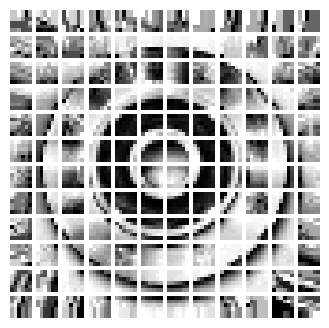

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image,cmap='gray')
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size,1))
    plt.imshow(patch_img.numpy(),cmap='gray')
    plt.axis("off")

In [14]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


In [15]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [16]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/10
24/24 [==============================] - 527s 21s/step - loss: 2.7109 - accuracy: 0.6358 - top-5-accuracy: 1.0000 - val_loss: 0.4602 - val_accuracy: 0.7846 - val_top-5-accuracy: 1.0000
Epoch 2/10
24/24 [==============================] - 500s 21s/step - loss: 0.5628 - accuracy: 0.7249 - top-5-accuracy: 1.0000 - val_loss: 0.4545 - val_accuracy: 0.7952 - val_top-5-accuracy: 1.0000
Epoch 3/10
24/24 [==============================] - 498s 21s/step - loss: 0.5134 - accuracy: 0.7562 - top-5-accuracy: 1.0000 - val_loss: 0.4642 - val_accuracy: 0.7636 - val_top-5-accuracy: 1.0000
Epoch 4/10
24/24 [==============================] - 473s 20s/step - loss: 0.4674 - accuracy: 0.7722 - top-5-accuracy: 1.0000 - val_loss: 0.3682 - val_accuracy: 0.8509 - val_top-5-accuracy: 1.0000
Epoch 5/10
24/24 [==============================] - 468s 20s/step - loss: 0.4328 - accuracy: 0.7975 - top-5-accuracy: 1.0000 - val_loss: 0.3613 - val_accuracy: 0.8569 - val_top-5-accuracy: 1.0000
Epoch 6/10
24/24 [==

# **Model Testing**

<ipython-input-49-cb19664683a4>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred_probability = vit_classifier.predict_generator(x_test)


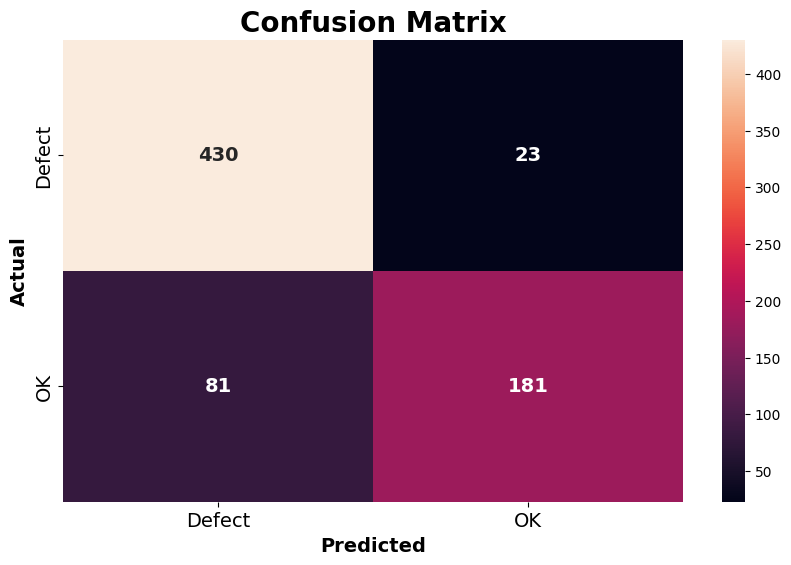

In [49]:
pred_probability = vit_classifier.predict_generator(x_test)
predictions = (pred_probability[:, 1] > 0.5).astype(int)

plt.figure(figsize=(10,6))
plt.title("Confusion Matrix", size=20, weight='bold')
sns.heatmap(
    confusion_matrix(y_test, predictions),
    annot=True,
    annot_kws={'size':14, 'weight':'bold'},
    fmt='d',
    xticklabels=['Defect', 'OK'],
    yticklabels=['Defect', 'OK'])
plt.tick_params(axis='both', labelsize=14)
plt.ylabel('Actual', size=14, weight='bold')
plt.xlabel('Predicted', size=14, weight='bold')
plt.show()